# Predicting Youtube View Count in 2007/2008

### Introduction

After being acquired by Google in 2006, Youtube obtained a rapid growth in popularity resulting in a growing community. The goal of this project is to use the data of 2007 to predict the view of videos in 2008. We will be using datasets from https://netsg.cs.sfu.ca/youtubedata/. The dataset uses a crawler to obtained video API and scrape the webpage for the remaining information.


In [ ]:
## TODO
-explain variables
-variable selection


### Methods

In [22]:
# Setup
library(tidyverse)
library(corrplot)
library(car)

In [2]:
## Load in May 5th 2007 data
table0007 <- read.delim("data/0007.txt", header = FALSE, sep = "\t", dec = ".")
table0107 <- read.delim("data/0107.txt", header = FALSE, sep = "\t", dec = ".")
table0207 <- read.delim("data/0207.txt", header = FALSE, sep = "\t", dec = ".")
table0307 <- read.delim("data/0307.txt", header = FALSE, sep = "\t", dec = ".")

data2007 <- rbind(table0007,table0107,table0207, table0307)|> na.omit()
colnames(data2007) <- c("Video ID", "uploader", "age", 'category','length','views','rate','ratings','comments','related IDs')

## Load in May 4th 2008 data
table0008 <- read.delim("data/0008.txt", header = FALSE, sep = "\t", dec = ".")
table0108 <- read.delim("data/0108.txt", header = FALSE, sep = "\t", dec = ".")
table0208 <- read.delim("data/0208.txt", header = FALSE, sep = "\t", dec = ".")
table0308 <- read.delim("data/0308.txt", header = FALSE, sep = "\t", dec = ".")

data2008 <- rbind(table0008,table0108,table0208, table0308)|> na.omit()
colnames(data2008) <- c("Video ID", "uploader", "age", 'category','length','views','rate','ratings','comments','related IDs')


#### Wrangling data
We decide to immediately remove some of the variables presented in the datasets. This included `uploader`,`video ID`, and `related IDs` because these variables appear to be unique to the videos itself and not affect video views as a whole.

In [3]:
#Read the data
data2007 <- data2007|> select(-c(1,2,10:29))
data2008 <- data2008 |>  select(-c(1,2,10:29))

In [4]:
# Remove any NA's
# data2007 <- na.omit(data2007)
# data2008 <- na.omit(data2008)
any(is.na(data2007))
head(data2007)

[1] FALSE

,age,category,length,views,rate,ratings,comments
,<dbl>,<chr>,<int>,<int>,<dbl>,<int>,<int>
1,807,Entertainment,28,1393810,4.16,1397,2888
2,808,News & Politics,133,208383,3.47,318,769
3,807,People & Blogs,28,135882,3.89,92,276
4,807,Howto & DIY,41,153590,1.58,2074,1230
5,807,Sports,99,92520,2.32,78,155
6,807,Entertainment,28,115085,3.73,84,207


### Preliminary Analysis

In [ ]:
#Observe the explanatory variables individually against the predictor, views.
par(mfrow=c(3,2))
plot(data2007$length,data2007$views, ylab = 'Views', xlab = 'Length', main = 'Views vs Length')
plot(data2007$rate,data2007$views, ylab = 'Views', xlab = 'Rate', main = 'Views vs Rate')
plot(data2007$ratings,data2007$views, ylab = 'Views', xlab = 'Ratings', main = 'Views vs Ratings')
plot(data2007$comments,data2007$views, ylab = 'Views', xlab = 'Comments', main = 'Views vs Comments')
plot(data2007$age,data2007$views, ylab = 'Views', xlab = 'Age', main = 'Views vs Age')
plot(data2007$comments,data2007$category, ylab = 'Views', xlab = 'Category', main = 'Views vs Category')

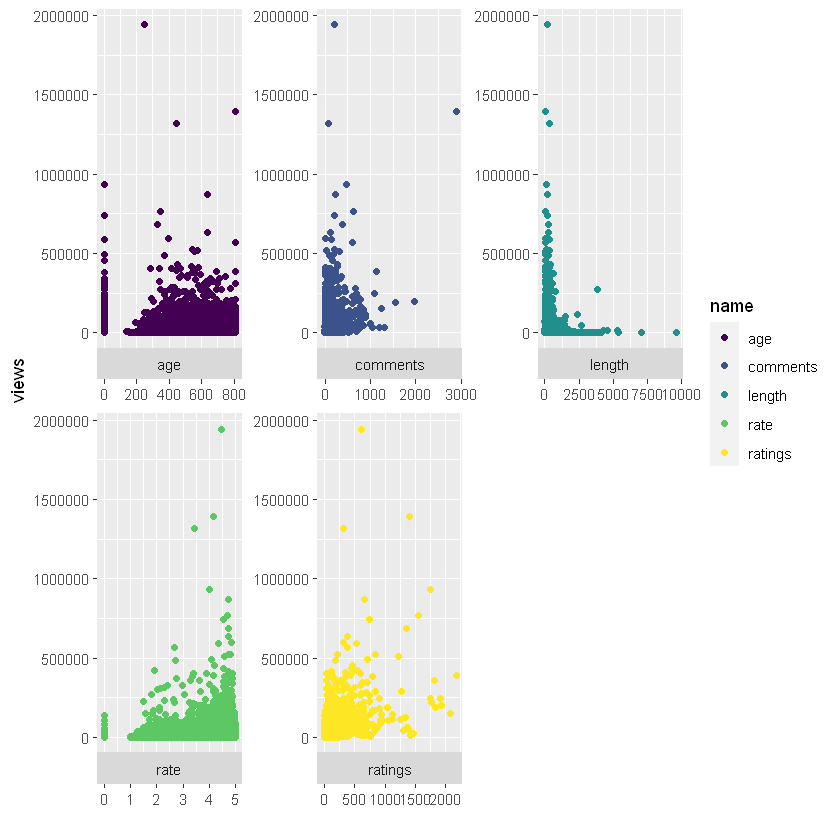

In [46]:
pivot_longer(data2007,-c(views,category))|> 
    ggplot(aes(value,views,color=name)) +
    geom_point() +
    facet_wrap(~name, scales ='free',strip.position='bottom') + 
    scale_color_viridis_d() + 
    xlab("") + ylab("views")

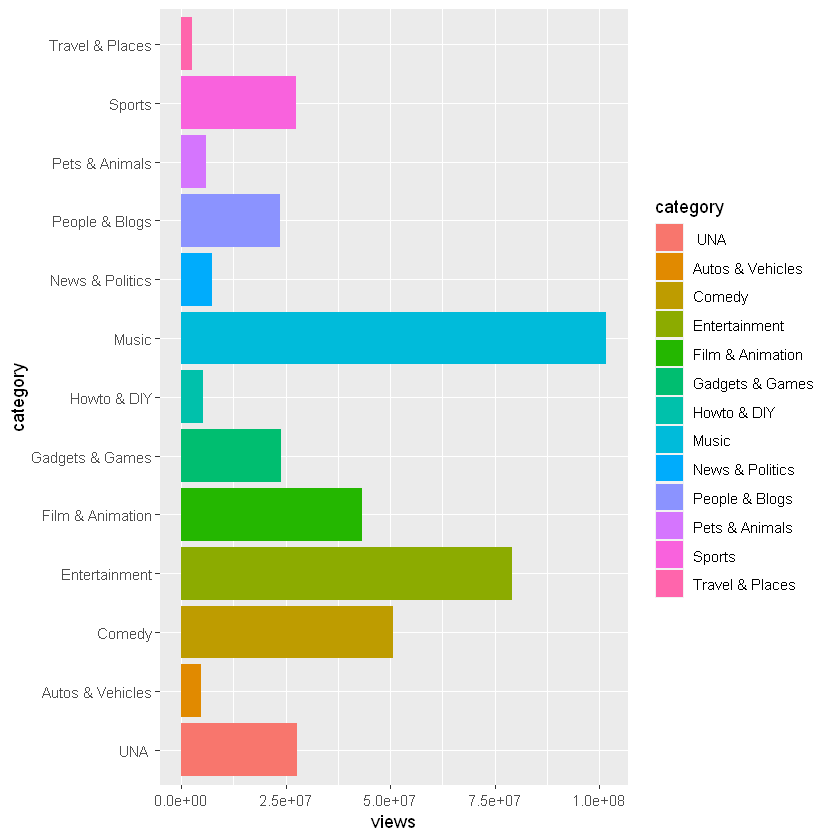

In [8]:
ggplot(data2007, aes(category,views, fill = category))+ geom_bar(stat = 'identity')+coord_flip()

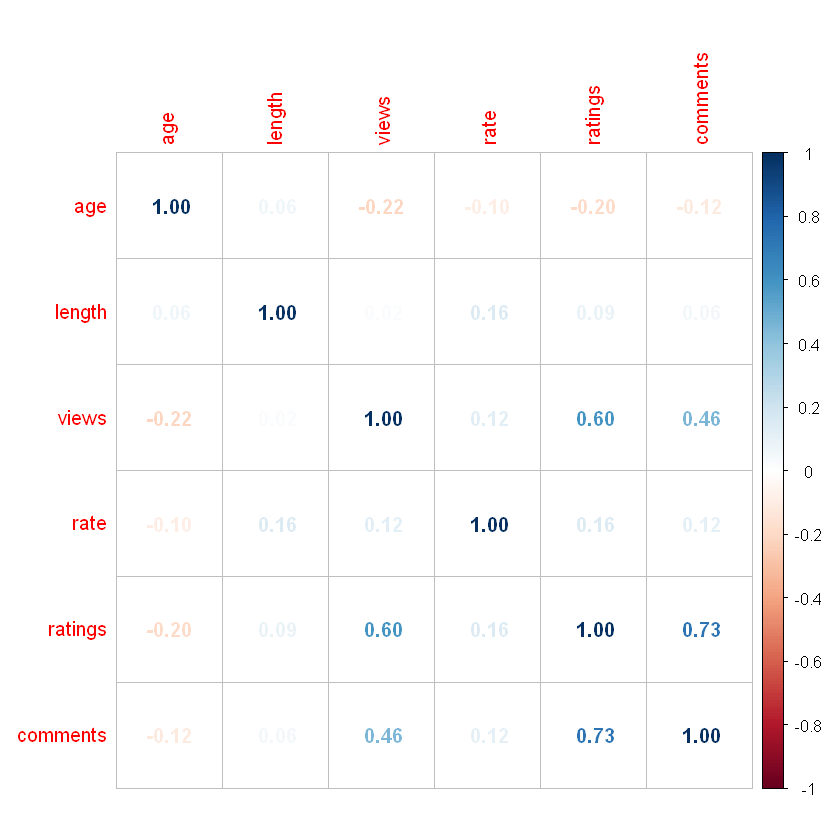

In [24]:
# Correlation plot
corrvar <- data2007|> select(-c(2))|> cor()
corrplot(corrvar, method = 'number')

Taking a look at the correlation plot, we can see that `ratings` and `comments` have the strong positive relationship with the predictive variable `views`. Meanwhile, the other explanatory variables have a very weak relationship with `views`. `ratings` has a positive correlation with `view` and `comments` too. Because there are explanatory variables with correlation against each other, we check if multicollinearity is significant by taking a look at the VIF scores.

In [26]:
vif(lm(views~.,data2007))

Warning message:
"In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument 'type' will be disregarded"


,GVIF,Df,GVIF^(1/(2*Df))
age,1.403040,1,1.184500
category,1.456405,12,1.015789
length,1.063942,1,1.031476
rate,1.090254,1,1.044152
ratings,2.261319,1,1.503768
comments,2.168201,1,1.472481


In [16]:
rownum <- sample(1:nrow(data2007), 0.75*nrow(data2007))
train <- data2007[rownum,]
test <- data2007[-rownum,]

It appears that the explanatory variables do not have a linear relationship with the predictor variable.

In [27]:
# Perform linear regression
#unclass() for categorical
mod <- lm(views~.,train)
summary(mod)
vif(mod)


Call:
lm(formula = views ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-372366   -2916   -1353     304 1240202 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.635e+04  8.431e+02  31.249  < 2e-16 ***
age                      -1.120e+01  7.235e-01 -15.487  < 2e-16 ***
categoryAutos & Vehicles -1.576e+04  1.145e+03 -13.764  < 2e-16 ***
categoryComedy           -1.703e+04  9.711e+02 -17.537  < 2e-16 ***
categoryEntertainment    -1.695e+04  9.650e+02 -17.561  < 2e-16 ***
categoryFilm & Animation -1.858e+04  9.892e+02 -18.786  < 2e-16 ***
categoryGadgets & Games  -1.814e+04  9.895e+02 -18.333  < 2e-16 ***
categoryHowto & DIY      -1.829e+04  1.157e+03 -15.805  < 2e-16 ***
categoryMusic            -1.694e+04  9.602e+02 -17.644  < 2e-16 ***
categoryNews & Politics  -1.897e+04  1.052e+03 -18.023  < 2e-16 ***
categoryPeople & Blogs   -1.757e+04  9.937e+02 -17.682  < 2e-16 ***
categoryPets & Animals   -1.84

,GVIF,Df,GVIF^(1/(2*Df))
age,1.400261,1,1.183326
category,1.456807,12,1.015800
length,1.063744,1,1.031380
rate,1.090947,1,1.044484
ratings,2.236629,1,1.495536
comments,2.147131,1,1.465309


Although there is a low p-value for the coefficients, the adjusted R-squared value is not particularly high and an extremely high standard error.

In [86]:
#Lets predict the number of views
prediction <- predict(mod,test)
summary(prediction)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -15781    1973    3418    6525    6197  635024      21 

[1] TRUE

[1] 15551

[1] 15551

In [89]:
#Calculate the RMSE
prediction <- na.omit(prediction)
test$views <- na.omit(test$views)
rmse <- sqrt(mean((test$views - prediction)^2))
rmse

[1] 18143.52

[1] 18143.52

It seems like the residual mean squared error is enormously high, which provides a good indication that this linear regression model is not well fitted.